## 1. 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from analysis import make_factor_score_df
from analysis import parallel_analysis_scree_plot
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
import pickle
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 불러오기

In [2]:
ts_rtn_df = pd.read_excel('data/ts_rtn.xlsx',dtype={'주식코드' : str})

In [3]:
# 2015~2020년 구간 필터링
df_2015_2020 = ts_rtn_df[(ts_rtn_df['연도'] >= 2015) & (ts_rtn_df['연도'] <= 2020)]

# 2021~2024년 구간 필터링
df_2021_2024 = ts_rtn_df[(ts_rtn_df['연도'] >= 2021) & (ts_rtn_df['연도'] <= 2024)]

# 파일로 저장
df_2015_2020.to_excel('data/ts_rtn_2015_2020.xlsx', index=False)
df_2021_2024.to_excel('data/ts_rtn_2021_2024.xlsx', index=False)

In [4]:
df = pd.read_excel('data/ts_rtn_2015_2020.xlsx',dtype={'주식코드' : str}).dropna()
df.head()

,회사명,주식코드,연도,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),총포괄이익증가율(IFRS),종업원1인당 부가가치증가율(IFRS),종업원수증가율(IFRS),종업원1인당 매출액증가율(IFRS),종업원1인당 인건비증가율(IFRS),매출액총이익률(IFRS),매출액정상영업이익률(IFRS),매출액순이익률(IFRS),총자본사업이익률(IFRS),총자본정상영업이익률(IFRS),총자본순이익률(IFRS),자기자본정상영업이익률(IFRS),자기자본순이익률(IFRS),경영자본정상영업이익률(IFRS),경영자본순이익률(IFRS),자본금정상영업이익률(IFRS),자본금순이익률(IFRS),매출원가 대 매출액비율(IFRS),영업비용 대 영업수익비율(IFRS),기타손익비률(IFRS),금융손익비율(IFRS),금융비용부담률(IFRS),외환이익 대 매출액비율(IFRS),광고선전비 대 매출액비율(IFRS),세금과공과 대 세금과공과 차감전순이익률(IFRS),기업순이익률(IFRS),수지비율(관계기업투자손익 제외)(IFRS),...,차입금의존도(IFRS),차입금비율(IFRS),유보액대비율(IFRS),유보액 대 납입자본배율(IFRS),유동자산집중도(IFRS),투자집중도(IFRS),CASH FLOW 대 부채비율(IFRS),CASH FLOW 대 차입금비율(IFRS),CASH FLOW 대 총자본비율(IFRS),CASH FLOW 대 매출액비율(IFRS),정상영업이익대비이자보상배율(IFRS),총자본회전률(IFRS),경영자본회전률(IFRS),자기자본회전률(IFRS),자본금회전률(IFRS),타인자본회전률(IFRS),매입채무회전률(IFRS),매입채무회전기간(IFRS),유동자산회전률(IFRS),당좌자산회전률(IFRS),재고자산회전률(IFRS),재고자산회전기간(IFRS),"상품,제품회전률(IFRS)","원,부재료회전률(IFRS)",재공품회전률(IFRS),매출채권회전률(IFRS),매출채권회전기간(IFRS),비유동자산회전률(IFRS),유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),부가가치율(IFRS),노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),수익률
0,(주)경방,000050,2015,-1.22,-4.16,-1.29,-1.31,0.11,8.61,3.10,19.75,20.36,51.76,53.52,22.16,-9.43,32.22,7.68,31.93,12.55,7.02,3.11,3.05,1.70,5.84,3.27,11.04,6.17,281.81,157.61,68.07,87.45,-3.38,-3.79,2.61,-0.14,0.18,60.94,2.34,91.01,...,24.32,45.60,52.25,48.01,27.20,111.79,6.26,12.02,2.92,11.96,4.81,0.24,0.88,0.47,22.45,0.51,17.50,20.86,3.68,6.46,8.52,42.82,22.41,15.21,143.96,9.64,37.88,0.26,1.17,0.88,1.51,0.02,8.57,41.80,379.17,35.08,19.66,80.34,20.01,-0.335878
1,(주)경방,000050,2016,-1.79,-3.70,-1.30,-1.64,-3.85,-10.48,2.75,1.99,10.22,43.38,43.53,9.17,-6.67,9.28,5.54,33.06,13.56,9.87,3.49,3.41,2.48,6.25,4.55,12.61,9.17,310.61,225.99,66.94,86.44,-2.76,-2.84,1.62,0.16,0.21,48.73,2.89,89.44,...,20.32,36.42,54.69,49.35,26.17,105.62,9.67,21.04,4.28,16.85,8.39,0.25,0.93,0.46,22.90,0.55,18.76,19.46,3.82,6.75,8.81,41.43,23.75,15.36,159.17,9.92,36.79,0.27,1.24,1.46,0.00,0.02,8.89,44.22,502.67,35.04,19.01,80.99,28.16,-0.155172
2,(주)경방,000050,2017,-3.07,-7.75,-1.26,-2.50,-11.26,-33.22,3.00,-8.21,-7.44,-17.10,-17.14,13.45,-12.37,4.75,8.93,34.62,13.68,8.91,3.31,3.24,2.11,5.63,3.67,12.32,8.03,287.51,187.34,65.38,86.32,-1.20,-1.43,1.45,-0.81,0.04,58.56,2.45,88.01,...,16.66,28.10,58.15,50.87,26.38,107.01,11.57,28.28,4.71,19.61,9.45,0.24,0.90,0.41,21.02,0.56,18.09,20.18,3.79,6.01,10.27,35.56,25.40,19.12,173.82,9.74,37.48,0.25,1.21,1.10,0.52,0.02,9.12,47.66,647.91,37.96,18.25,81.75,23.48,0.013605
3,(주)경방,000050,2018,2.29,-6.58,-1.13,0.96,23.35,58.28,2.56,-3.13,-1.11,13.70,12.03,-11.79,-8.15,5.47,-3.87,36.29,13.96,10.46,3.35,3.21,2.41,5.41,4.05,12.66,9.49,284.31,213.01,63.71,86.04,-1.01,-3.20,1.14,0.43,0.11,35.45,2.67,87.45,...,17.26,29.04,58.79,52.60,28.60,110.06,8.11,19.06,3.29,14.46,12.20,0.23,0.91,0.39,20.36,0.57,17.82,20.49,3.50,5.49,9.62,37.96,22.70,18.34,184.18,9.86,37.03,0.25,1.26,1.09,0.60,0.02,7.22,41.34,1552.83,31.75,19.89,80.11,32.96,-0.248322
4,(주)경방,000050,2019,5.68,-69.74,5.71,-5.79,153.86,-60.76,1.58,-9.15,-0.01,-23.89,-24.03,62.43,-43.94,62.06,29.47,40.22,15.37,8.77,3.37,3.09,1.76,5.30,3.02,18.06,10.30,284.27,162.13,59.78,84.63,-2.55,-2.03,0.79,-0.04,0.13,47.26,1.92,89.28,...,18.56,32.48,56.95,53.86,61.52,49.08,8.52,19.68,3.65,18.68,19.56,0.20,1.17,0.34,18.50,0.48,15.39,23.72,1.63,1.93,10.24,35.65,23.07,19.64,292.24,9.50,38.43,0.23,1.82,0.90,0.23,0.02,6.22,134.74,18933.42,31.82,15.85,84.15,27.55,-0.107143


##### 무한대 값이 있는 경우 제거, 상관분석 위해 (회사명, 주식코드, 연도, 수익률 제외)

In [5]:
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna().iloc[:,3:-1]

## 3. 상관분석
- 자기상관(상관계수가 0.9 이상인 컬럼쌍) 처리
- 대각성분을 제외하고 상관계수의 절댓값이 0.5이하인 값들만 구성되어있는 컬럼 처리

##### 상관관계 분석 후 자기상관 처리

In [6]:
corr_matrix = df_clean.corr().abs()

print("--- 상관 행렬 (절댓값) ---")
print(corr_matrix)
print("-" * 50)

# 중복된 쌍을 제외하고 대각선을 제외한 값들만 추출
# 상관 행렬은 대칭적이므로, 중복된 쌍(예: (A,B)와 (B,A))을 피하고
# 자기 자신과의 상관관계(대각선 값, 항상 1)도 제외합니다.
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 극도로 높은 상관관계를 가진 변수 쌍 찾기
# 임계값(threshold) 설정: 0.95, 0.99 등 매우 높은 값을 사용합니다.
# 1에 가까울수록 선형 종속성이 강합니다.
threshold = 0.9
highly_correlated_pairs = upper_tri.stack()
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs >= threshold]

print(f"--- 상관 계수 절댓값 {threshold} 이상인 변수 쌍 ---")
if not highly_correlated_pairs.empty:
    print(highly_correlated_pairs.sort_values(ascending=False))
    print("\n이 변수 쌍 중 하나를 제거해야 할 가능성이 높습니다.")

    # 제거할 변수 목록 (예시 로직: 각 쌍에서 두 번째 변수를 제거)
    # 실제로는 도메인 지식을 바탕으로 어떤 변수를 제거할지 결정하는 것이 좋습니다.
    # (예: 정보량이 더 적거나, 이론적으로 덜 중요한 변수)
    cols_to_drop = []
    for (col1, col2), corr_val in highly_correlated_pairs.items():
        if col2 not in cols_to_drop: # 이미 제거 목록에 없는 경우만 추가
            cols_to_drop.append(col2) # 일단 두 번째 변수를 제거 후보로 추가

    # 중복 제거 (필요하다면)
    cols_to_drop = list(set(cols_to_drop))

    if cols_to_drop:
        print(f"\n제거할 변수 후보: {cols_to_drop}")
        x_data_cleaned = df_clean.drop(columns=cols_to_drop)
        print("\n--- 상관관계 높은 변수 제거 후 x_data의 shape ---")
        print(x_data_cleaned.shape)
        print(f"남은 컬럼: {x_data_cleaned.columns.tolist()}")
    else:
        x_data_cleaned = df_clean.copy() # 제거할 컬럼이 없으면 원본 유지
        print("제거할 변수 후보가 없습니다.")

else:
    print("설정한 임계값 이상의 극도로 높은 상관관계를 가진 변수 쌍이 없습니다.")
    x_data_cleaned = df_clean.copy() # 제거할 컬럼이 없으면 원본 유지

--- 상관 행렬 (절댓값) ---
                총자본증가율(IFRS)  유형자산증가율(IFRS)  ...  자본분배율(IFRS)  이윤분배율(IFRS)
총자본증가율(IFRS)        1.000000       0.020970  ...     0.039907     0.080937
유형자산증가율(IFRS)       0.020970       1.000000  ...     0.003285     0.002134
투자부동산증가율(IFRS)      0.020738       0.001441  ...     0.004283     0.000630
비유동자산증가율(IFRS)      0.818722       0.002619  ...     0.024834     0.059723
유동자산증가율(IFRS)       0.227773       0.064774  ...     0.018286     0.026214
...                      ...            ...  ...          ...          ...
기계투자효율(IFRS)        0.003579       0.002564  ...     0.004656     0.000566
부가가치율(IFRS)         0.171749       0.004093  ...     0.050377     0.041511
노동소득분배율(IFRS)       0.035067       0.003618  ...     0.999000     0.242229
자본분배율(IFRS)         0.039907       0.003285  ...     1.000000     0.242625
이윤분배율(IFRS)         0.080937       0.002134  ...     0.242625     1.000000

[114 rows x 114 columns]
--------------------------------------------------
---

##### 대각성분을 제외하고 상관계수의 절댓값이 0.5이하인 값들만 구성되어있는 컬럼 처리
- 상관계수의 절댓값이 0.5이하면 다른 피쳐들과 관계가 적으므로 제외해야겠다고 판단

In [7]:
# 상관관계가 0.5보다 낮은 값들만 구성된 컬럼은 제거
corr = x_data_cleaned.corr()

# 각 컬럼별로, 자기 자신을 제외한 나머지 컬럼들과의 상관계수 절대값이 모두 0.5 미만인지 확인
cols_to_drop = []
for col in corr.columns:
    # 자기 자신 제외 (상관계수 1)
    other_corrs = corr[col].drop(col)
    if all(other_corrs.abs() < 0.5):
        cols_to_drop.append(col)

# 해당 컬럼 삭제
filtered_data = x_data_cleaned.drop(columns=cols_to_drop)
filtered_data

,총자본증가율(IFRS),유형자산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),매출액증가율(IFRS),종업원1인당 부가가치증가율(IFRS),종업원수증가율(IFRS),매출액정상영업이익률(IFRS),매출액순이익률(IFRS),총자본사업이익률(IFRS),총자본순이익률(IFRS),자기자본정상영업이익률(IFRS),자기자본순이익률(IFRS),경영자본정상영업이익률(IFRS),경영자본순이익률(IFRS),자본금정상영업이익률(IFRS),자본금순이익률(IFRS),기타손익비률(IFRS),금융손익비율(IFRS),금융비용부담률(IFRS),수지비율(관계기업투자손익 제외)(IFRS),금융비용 대 총비용비율(IFRS),감가상각비 대 총비용비율(IFRS),지급이자율(IFRS),차입금평균이자율(IFRS),유보율(IFRS),사내유보 대 자기자본비율(IFRS),적립금비율(재정비율)(IFRS),평균배당률(IFRS),자기자본배당률(IFRS),유동자산구성비율(IFRS),유동자산 대 비유동자산비율(IFRS),자기자본구성비율(IFRS),비유동비율(IFRS),비유동장기적합률(IFRS),유동비율(IFRS),현금비율(IFRS),매출채권비율(IFRS),재고자산 대 순운전자본비율(IFRS),매입채무 대 재고자산비율(IFRS),유동부채비율(IFRS),비유동부채 대 순운전자본비율(IFRS),순운전자본비율(IFRS),차입금의존도(IFRS),투자집중도(IFRS),CASH FLOW 대 부채비율(IFRS),CASH FLOW 대 차입금비율(IFRS),CASH FLOW 대 총자본비율(IFRS),CASH FLOW 대 매출액비율(IFRS),총자본회전률(IFRS),자기자본회전률(IFRS),자본금회전률(IFRS),타인자본회전률(IFRS),유동자산회전률(IFRS),당좌자산회전률(IFRS),비유동자산회전률(IFRS),유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),총자본투자효율(IFRS),부가가치율(IFRS)
0,-1.22,-4.16,-1.31,0.11,19.75,22.16,-9.43,12.55,7.02,3.11,1.70,5.84,3.27,11.04,6.17,281.81,157.61,-3.38,-3.79,2.61,91.01,2.81,8.19,2.88,2.71,4800.71,3.19,97.99,25.00,0.51,6.65,7.12,53.34,175.02,105.39,58.20,2.78,84.27,0.00,44.74,21.42,0.00,-4.78,24.32,111.79,6.26,12.02,2.92,11.96,0.24,0.47,22.45,0.51,3.68,6.46,0.26,1.17,0.88,1.51,8.57,35.08
1,-1.79,-3.70,-1.64,-3.85,1.99,9.17,-6.67,13.56,9.87,3.49,2.48,6.25,4.55,12.61,9.17,310.61,225.99,-2.76,-2.84,1.62,89.44,1.77,8.21,2.39,2.16,4935.48,4.57,98.05,36.00,0.71,6.51,6.96,55.80,167.55,103.59,66.76,2.60,93.89,0.00,49.45,17.48,0.00,-3.24,20.32,105.62,9.67,21.04,4.28,16.85,0.25,0.46,22.90,0.55,3.82,6.75,0.27,1.24,1.46,0.00,8.89,35.04
2,-3.07,-7.75,-2.50,-11.26,-8.21,13.45,-12.37,13.68,8.91,3.31,2.11,5.63,3.67,12.32,8.03,287.51,187.34,-1.20,-1.43,1.45,88.01,1.58,8.81,2.53,2.24,5086.63,3.69,98.11,36.00,0.69,5.96,6.34,59.29,158.60,118.73,28.67,1.88,122.62,0.00,67.68,35.07,0.00,-14.83,16.66,107.01,11.57,28.28,4.71,19.61,0.24,0.41,21.02,0.56,3.79,6.01,0.25,1.21,1.10,0.52,9.12,37.96
3,2.29,-6.58,0.96,23.35,-3.13,-11.79,-8.15,13.96,10.46,3.35,2.41,5.41,4.05,12.66,9.49,284.31,213.01,-1.01,-3.20,1.14,87.45,1.27,8.95,2.31,2.38,5260.30,4.12,98.99,24.60,0.46,7.19,7.74,59.45,156.12,101.31,85.68,3.02,81.70,0.00,45.30,14.11,0.00,-1.20,17.26,110.06,8.11,19.06,3.29,14.46,0.23,0.39,20.36,0.57,3.50,5.49,0.25,1.26,1.09,0.60,7.22,31.75
4,5.68,-69.74,-5.79,153.86,-9.15,62.43,-43.94,15.37,8.77,3.37,1.76,5.30,3.02,18.06,10.30,284.27,162.13,-2.55,-2.03,0.79,89.28,0.74,8.77,2.32,2.46,5385.78,2.87,99.82,24.09,0.45,17.26,20.87,57.14,144.78,93.60,148.68,2.62,174.25,19.05,120.63,20.32,552.74,5.65,18.56,49.08,8.52,19.68,3.65,18.68,0.20,0.34,18.50,0.48,1.63,1.93,0.23,1.82,0.90,0.23,6.22,31.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.12,-7.14,12.09,-6.86,17.91,-20.92,12.41,-14.49,291.68,-340.61,-5.03,-2.45,-4.62,81.38,-5.15,2.73,3.39,3.39,1536.85,-23.07,94.38,0.00,0.00,17.50,21.21,32.82,251.39,125.19,51.32,0.26,62.89,0.00,60.87,103.89,0.00,-16.60,52.18,49.29,11.35,14.61,7.63,7.93,0.96,2.93,47.69,1.43,5.49,11.99,1.17,2.97,1.86,0.10,6.55,6.81
1540,2.53,-10.43,0.96,9.94,-32.36,71.90,-3.66,1.13,6.58,5.44,4.23,2.10,12.26,1.71,10.00,36.42,212.40,4.65,-2.68,-4.87,94.81,-4.61,4.16,3.16,3.12,1746.42,-9.04,95.02,0.00,0.00,18.76,23.10,36.13,224.86,142.19,43.77,0.44,71.46,0.00,97.11,118.65,0.00,-24.11,49.65,58.88,14.46,18.60,9.24,14.57,0.64,1.86,32.26,0.98,3.54,6.09,0.78,2.12,1.13,0.10,10.57,16.68
1541,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.23,4.28,4.46,2.93,6.65,4.57,4.53,3.11,284.44,195.44,-0.48,-0.50,0.50,94.29,0.52,4.95,3.00,3.00,4180.17,53.42,97.72,94.00,2.20,35.85,55.87,64.11,100.06,76.31,225.10,49.88,342.70,25.40,175.09,24.84,100.20,19.92,18.09,137.61,24.20,47.99,8.68,12.70,0.68,1.07,45.65,1.91,1.91,2.22,1.07,1.23,1.32,0.10,11.34,16.59
1542,

## 4. 요인분석

##### 요인 분석에 대한 적합성 검정
- KMO 검정
- 바틀렛 검정

##### KMO 검정

In [8]:
kmo_all, kmo_model = calculate_kmo(filtered_data)
print(f"KMO 전체 통계량: {kmo_model:.4f}")
if kmo_model >= 0.6:
    print("→ 요인 분석에 적합한 데이터입니다 (KMO ≥ 0.6)")
else:
    print("→ 요인 분석에 부적합할 수 있습니다 (KMO < 0.6)")

KMO 전체 통계량: 0.6567
→ 요인 분석에 적합한 데이터입니다 (KMO ≥ 0.6)


##### Bartlett's Test

In [9]:
chi_square_value, p_value = calculate_bartlett_sphericity(filtered_data)
print(f"Bartlett's Test Chi-square: {chi_square_value:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ 변수 간 상관관계가 존재하므로 요인분석 적합")
else:
    print("→ 상관관계가 부족하여 요인분석에 적합하지 않을 수 있음")

Bartlett's Test Chi-square: 103864.58, p-value: 0.0000
→ 변수 간 상관관계가 존재하므로 요인분석 적합


##### 최적의 팩터 개수 찾기
- analysis.py에서 parallel_analysis_scree_plot 함수 이용

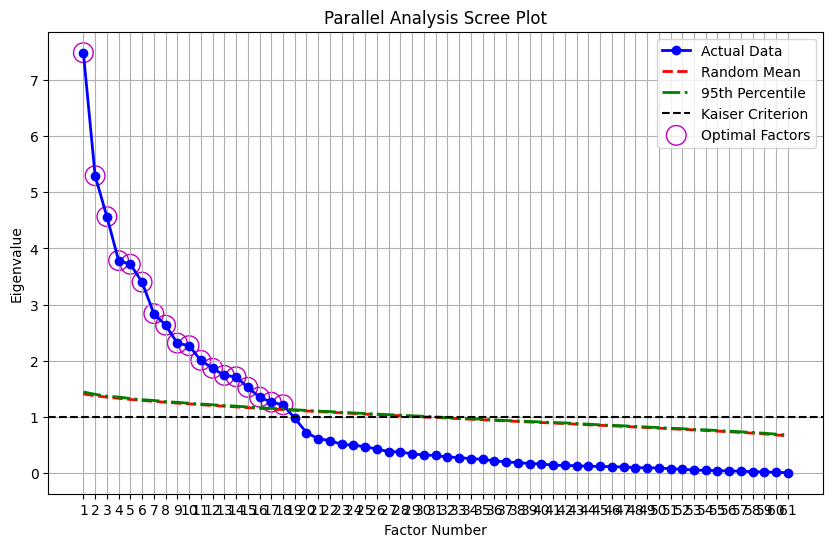

Suggested number of factors: 18


,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17,factor_18
0,0.263519,-0.206409,0.149008,-0.045641,-0.106330,-0.104393,-0.233392,-0.066183,-0.018716,0.030485,-1.207363,-0.118464,-0.230228,-0.289919,-0.040948,-0.045972,-0.049833,-0.303110
1,0.257811,0.118021,0.074366,0.021672,-0.091815,-0.125344,0.018015,-0.107424,-0.024604,0.038406,-1.317805,-0.114484,-0.263116,-0.231640,-0.153382,-0.031656,-0.084723,-0.292318
2,0.216669,-0.086879,0.043269,-0.010187,-0.080200,-0.125409,-0.024860,-0.193909,-0.015402,0.092578,-1.462775,-0.145096,-0.333981,-0.168443,-0.057920,-0.072257,-0.128612,-0.379770
3,0.261598,-0.182074,0.063602,0.008177,-0.115090,-0.145049,0.109181,-0.143024,-0.038292,0.042239,-1.198121,-0.116146,-0.127053,-0.335966,-0.126557,-0.047627,0.066662,-0.302198
4,0.217320,-0.798709,-0.115138,-0.005158,-0.091597,-0.196157,0.013962,-0.462033,-0.077046,0.112284,-0.716852,0.067916,-0.191102,-0.291156,-0.189625,-0.054333,0.903579,-0.283512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,-0.063014,1.456542,-0.002409,-0.194134,-0.228430,-0.179348,-1.319949,-0.017068,-0.004226,-0.213988,-1.162316,-0.158196,-0.279058,0.232992,0.229289,0.051115,-0.020904,0.209108
1540,0.007050,0.314316,-0.246202,0.200329,-0.248353,-0.186146,-1.324321,-0.204698,-0.001553,-0.021097,-1.103233,-0.196625,-0.089630,0.085441,0.020279,-0.078071,-0.072178,-0.100276
1541,0.181019,-0.235563,-0.154403,-0.034667,0.060409,-0.030176,0.217960,-0.043180,-0.077059,-0.139426,-0.011372,-0.062513,-0.268754,0.077905,-0.039863,-0.096088,-0.114342,-0.105462
1542,0.157357,-0.580549,-0.139185,-0.152737,-0.207853,-0.068450,-0.042019,-0.140507,-0.056566,-0.250697,-0.523015,0.010200,1.613579,0.291494,0.079542,-0.176710,-0.171816,-0.301063


In [10]:
optim = parallel_analysis_scree_plot(filtered_data, n_iter=100, random_state=42)

X_data = make_factor_score_df(optim,filtered_data)
X_data

## 5. RLM

##### VIF 계산 위해 상수항 추가

In [11]:
y = df.iloc[:,-1]
X_data = sm.add_constant(X_data)

y.index = X_data.index
model = sm.RLM(y,X_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                    수익률   No. Observations:                 1544
Model:                            RLM   Df Residuals:                     1525
Method:                          IRLS   Df Model:                           18
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 28 May 2025                                         
Time:                        15:39:38                                         
No. Iterations:                    24                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.009      0.243      0.808      -0.015       0.019
factor_1       0.0181      0.009      2.069      0.039       0.001       0.035
factor_2      -0.0172      0.009     -1.969      0.049      -0.034   -8.22e-05
factor_3       0.0063      0.009      0.718      0.473      -0.011       0.023
factor_4      -0.0199      0.009     -2.277      0.023      -0.037      -0.003
factor_5       0.0028      0.009      0.323      0.747      -0.014       0.020
factor_6       0.0069      0.009      0.785      0.432      -0.010       0.024
factor_7       0.0086      0.009      0.982      0.326      -0.009       0.026
factor_8      -0.0057      0.009     -0.657      0.511      -0.023       0.011
factor_9      -0.0007      0.009     -0.079      0.937      -0.018       0.016
factor_10      0.0235      0.009      2.688      0.007       0.006       0.041
factor_11      0.0026      0.009      0.299      0.765      -0.015       0.020
factor_12     -0.0002      0.009     -0.025      0.980      -0.017       0.017
factor_13      0.0040      0.009      0.462      0.644      -0.013       0.021
factor_14      0.0332      0.009      3.804      0.000       0.016       0.050
factor_15     -0.0086      0.009     -0.982      0.326      -0.026       0.009
factor_16      0.0040      0.009      0.460      0.646      -0.013       0.021
factor_17      0.0015      0.009      0.175      0.861      -0.016       0.019
factor_18     -0.0069      0.009     -0.794      0.427      -0.024       0.010
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

##### 요인분석 - method : principal
- stnadardscaler 사용

In [12]:
fa = FactorAnalyzer(n_factors=optim,rotation='varimax',method='principal')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)
fa_fit = fa.fit(scaled_data)

##### 요인 점수 추출 및 특정 요인 선택
- 요인분석 결과로부터 추출한 요인 부하량(loadings)을 기반으로 요인 점수 데이터프레임을 생성
- 전체 요인 중에서 관심 있는 요인(factor_6, factor_10, factor_11, factor_13, factor_14)만 선택하여 후속 분석에 활용

In [13]:
factor_df = pd.DataFrame(fa_fit.loadings_,columns=[f"factor_{i+1}" for i in range(optim)],index=filtered_data.columns)
factor_df = factor_df[['factor_1', 'factor_2', 'factor_4', 'factor_10', 'factor_14']]

##### 요인 부하량 결과 시각화 및 저장

In [14]:
with pd.ExcelWriter('data/valid_factor_loadings_fix.xlsx', engine='xlsxwriter') as writer:
    (factor_df.style
     .background_gradient(cmap='coolwarm', axis=1, vmin=-1, vmax=1)
     .to_excel(writer, sheet_name='Factor Loadings'))

##### BackTesting.ipynb에 이용할 적재 행렬과 요인 점수 데이터 보내기 위해 객체에 저장

In [16]:
factor_list = ['factor_1','factor_2','factor_4','factor_10','factor_14']
# 적재 행렬과 요인 점수 데이터 보내기
X_data.to_excel('data/factor_score.xlsx',index=False)
factor_df.to_excel('data/factor_loadings.xlsx',index=False)

# 회귀계수 데이터, fa 객체 저장
factor_coefficients_for_backtest = results.params[factor_list]

with open("data/coef.pickle",'wb') as f:
    pickle.dump(factor_coefficients_for_backtest,f)
    pickle.dump(fa,f)